In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sricharan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sricharan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv("imdb_master.csv", encoding='latin1')
df.dropna(inplace=True)

Loading dataset...


In [3]:
# Keep only labeled data (remove 'unsup')
print("Filtering labeled data...")
df = df[df['label'] != 'unsup']

# Mapping labels to numerical values
df['label'] = df['label'].map({'neg': 0, 'pos': 1})

# Preprocessing functions
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z ]', ' ', text)  # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(lemmatizer.lemmatize(word, pos='v'), pos='n') for word in words]
    cleaned_words = [word for word in lemmatized_words if word not in stop_words]  # Remove stopwords
    return ' '.join(cleaned_words)

print("Cleaning text data...")
df['clean_review'] = df['review'].apply(clean_text)


Filtering labeled data...
Cleaning text data...


Generating word clouds...


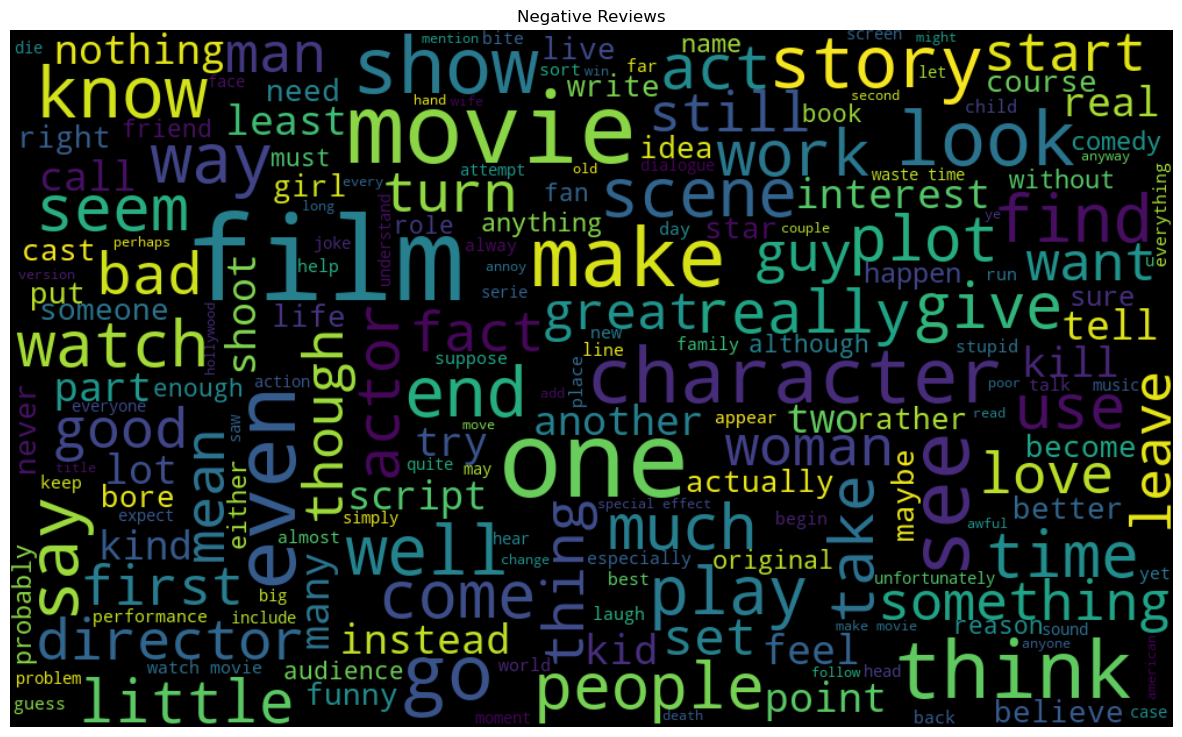

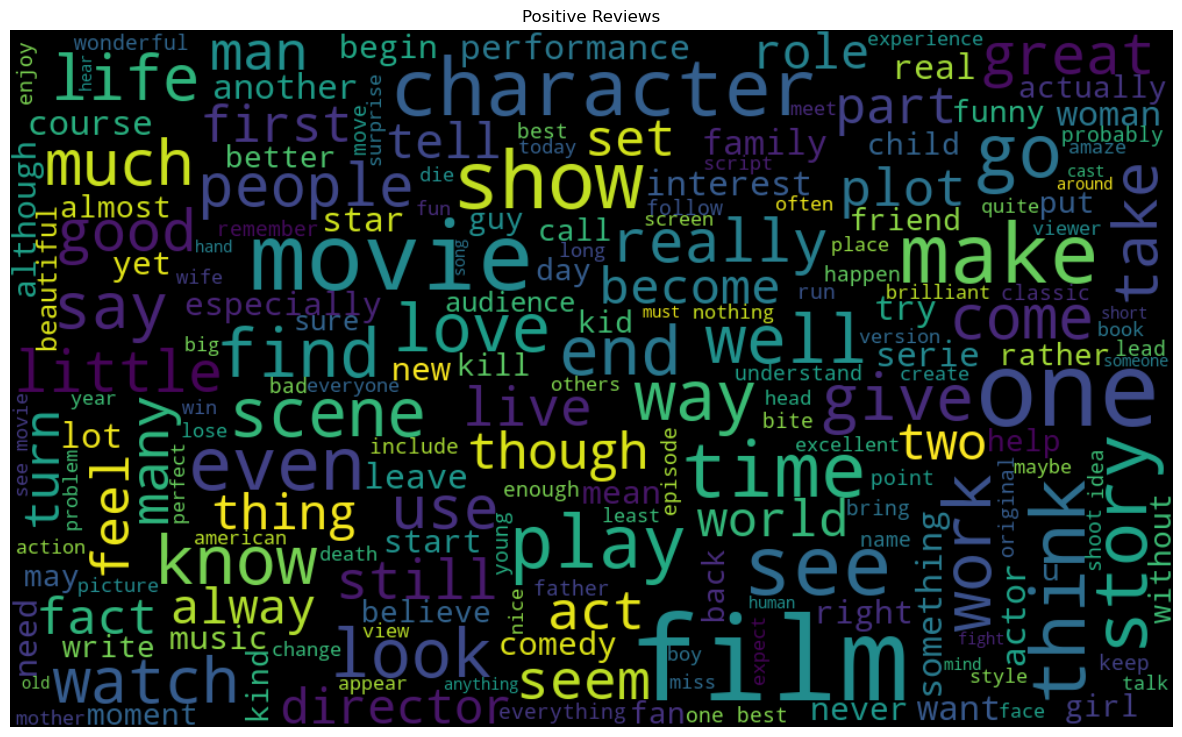

In [4]:
# Generate Word Clouds
print("Generating word clouds...")
for sentiment, title in [(0, 'Negative Reviews'), (1, 'Positive Reviews')]:
    reviews = ' '.join(df['clean_review'][df['label'] == sentiment].astype(str))
    wordcloud = WordCloud(height=600, width=1000, max_font_size=100).generate(reviews)
    plt.figure(figsize=(15, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


In [5]:
df.to_csv('cleaned_data.csv')

In [6]:
# Splitting data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['label'], test_size=0.2, random_state=42)

Splitting data...


In [7]:
# TF-IDF Vectorization
print("Applying TF-IDF vectorization...")
vectorizer = TfidfVectorizer(max_features=2500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Get the selected words (features) by TF-IDF
selected_words = vectorizer.get_feature_names_out()

# Display the first 50 wo
selected_words

Applying TF-IDF vectorization...


array(['abandon', 'ability', 'able', ..., 'youth', 'zero', 'zombie'],
      dtype=object)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define hyperparameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 30.0]}

# Initialize model
nb = MultinomialNB()

# Apply GridSearchCV
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Get best parameters
best_alpha = grid_search.best_params_['alpha']
print(f"✅ Best Alpha for Naïve Bayes: {best_alpha}")

# Train final model with best alpha
best_nb = MultinomialNB(alpha=best_alpha)
best_nb.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_nb = best_nb.predict(X_test_tfidf)
nb_acc = accuracy_score(y_test, y_pred_nb)
print(f"✅ Final Naïve Bayes Accuracy: {nb_acc:.4f}")


Fitting 5 folds for each of 7 candidates, totalling 35 fits
✅ Best Alpha for Naïve Bayes: 5.0
✅ Final Naïve Bayes Accuracy: 0.8509


<Axes: >

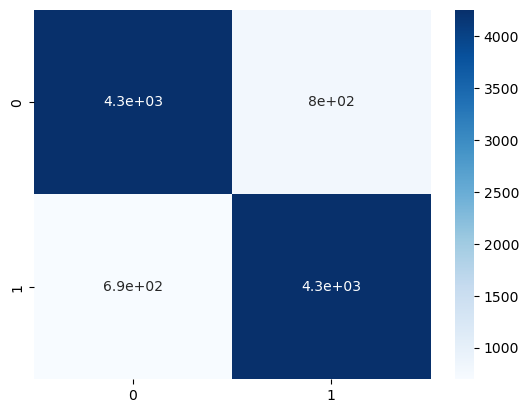

In [9]:
sns.heatmap( confusion_matrix(y_test, y_pred_nb),annot=True, cmap="Blues")

In [14]:
# Load new dataset
ratings_df = pd.read_csv("rating_reviews.csv")
from tqdm import tqdm
tqdm.pandas()  # Enables tqdm progress bar for pandas

ratings_df['clean_review'] = ratings_df['review'].progress_apply(clean_text)

# Predict sentiment scores
ratings_df['sentiment_scores'] = best_nb.predict_proba(vectorizer.transform(ratings_df['clean_review']))[:, 1]

# Map sentiment scores to ratings (1-5) using quantiles
ratings_df['predicted_rating'] = pd.qcut(ratings_df['sentiment_scores'], q=5, labels=[1, 2, 3, 4, 5])

# Display a preview
ratings_df[['clean_review', 'sentiment_scores', 'predicted_rating']].head(6)


100%|██████████| 100836/100836 [10:18<00:00, 163.10it/s]


,clean_review,sentiment_scores,predicted_rating
0,gun play direct enzo g castellari good pastich...,0.346900,2
1,officially first martial art movie ussr cinema...,0.539929,3
2,extra film part shoot airport first minute one...,0.224517,1
3,superbly adapt screen extremely faithful mary ...,0.709707,4
4,julie water outstanding adrian pasdar revelati...,0.818347,5
5,documentary bore quite stupid mean documentary...,0.247029,1


In [15]:
ratings_df.head(6)

,userId,movieId,rating,timestamp,review,clean_review,sentiment_scores,predicted_rating
0,1,1,4.0,964982703,"""Any Gun Can Play"" (1967), directed by Enzo G....",gun play direct enzo g castellari good pastich...,0.346900,2
1,1,3,4.0,964981247,Officially the first martial arts movie in USS...,officially first martial art movie ussr cinema...,0.539929,3
2,1,6,4.0,964982224,"I was an extra on this film, in the part shot ...",extra film part shoot airport first minute one...,0.224517,1
3,1,47,5.0,964983815,Superbly adapted to the screen and extremely f...,superbly adapt screen extremely faithful mary ...,0.709707,4
4,1,50,5.0,964982931,Julie Waters is outstanding and Adrian Pasdar ...,julie water outstanding adrian pasdar revelati...,0.818347,5
5,1,70,3.0,964982400,"This documentary was boring, and quite stupid....",documentary bore quite stupid mean documentary...,0.247029,1


In [16]:
# Combine actual and predicted ratings using weighted average (0.8 * original + 0.2 * predicted)
ratings_df['final_rating'] = (0.8 * ratings_df['rating'] + 0.2 * ratings_df['predicted_rating'].astype(float)).round()

# Display a preview
ratings_df.head()

,userId,movieId,rating,timestamp,review,clean_review,sentiment_scores,predicted_rating,final_rating
0,1,1,4.0,964982703,"""Any Gun Can Play"" (1967), directed by Enzo G....",gun play direct enzo g castellari good pastich...,0.346900,2,4.0
1,1,3,4.0,964981247,Officially the first martial arts movie in USS...,officially first martial art movie ussr cinema...,0.539929,3,4.0
2,1,6,4.0,964982224,"I was an extra on this film, in the part shot ...",extra film part shoot airport first minute one...,0.224517,1,3.0
3,1,47,5.0,964983815,Superbly adapted to the screen and extremely f...,superbly adapt screen extremely faithful mary ...,0.709707,4,5.0
4,1,50,5.0,964982931,Julie Waters is outstanding and Adrian Pasdar ...,julie water outstanding adrian pasdar revelati...,0.818347,5,5.0


In [30]:
# Load movies dataset
print("Loading movies dataset...")
movies_df = pd.read_csv("movies.csv")
movie_id_to_title = dict(zip(movies_df['id'], movies_df['title']))
movies_df[['id', 'title']]

Loading movies dataset...


,id,title
0,19995,Avatar
1,285,Pirates of the Caribbean: At World's End
2,206647,Spectre
3,49026,The Dark Knight Rises
4,49529,John Carter
...,...,...
4798,9367,El Mariachi
4799,72766,Newlyweds
4800,231617,"Signed, Sealed, Delivered"
4801,126186,Shanghai Calling


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
# Collaborative Filtering for Movie Recommendation using ratings_df
print("Creating user-item matrix from ratings_df...")
user_movie_matrix = ratings_df.pivot(index="userId", columns="movieId", values="final_rating").fillna(0)

# Compute User Similarity Matrix
print("Computing user similarity matrix...")
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

Creating user-item matrix from ratings_df...
Computing user similarity matrix...


In [23]:
user_movie_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
user_similarity_df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027944,0.063992,0.191959,0.128820,0.128345,0.157892,0.139359,0.065145,0.018418,...,0.083235,0.165368,0.220951,0.070753,0.152457,0.162911,0.271311,0.289902,0.094687,0.144717
2,0.027944,1.000000,0.000000,0.003377,0.016817,0.025847,0.027042,0.027741,0.000000,0.063180,...,0.192796,0.017077,0.011637,0.000000,0.000000,0.024904,0.013248,0.043858,0.027901,0.102460
3,0.063992,0.000000,1.000000,0.004604,0.010188,0.008053,0.000000,0.010083,0.000000,0.000000,...,0.010571,0.009931,0.031270,0.000000,0.012594,0.019219,0.025041,0.029348,0.000000,0.036483
4,0.191959,0.003377,0.004604,1.000000,0.129624,0.089866,0.116157,0.063789,0.011466,0.034725,...,0.090998,0.128832,0.306987,0.053766,0.085789,0.201944,0.133491,0.151045,0.032439,0.107645
5,0.128820,0.016817,0.010188,0.129624,1.000000,0.297678,0.106302,0.431427,0.000000,0.032512,...,0.070206,0.417895,0.108356,0.260632,0.153533,0.111726,0.152254,0.134646,0.261232,0.060975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.162911,0.024904,0.019219,0.201944,0.111726,0.103247,0.204102,0.098872,0.078741,0.092727,...,0.179189,0.117723,0.300681,0.067617,0.148101,1.000000,0.150973,0.263296,0.070331,0.196982
607,0.271311,0.013248,0.025041,0.133491,0.152254,0.163455,0.188193,0.185929,0.011994,0.013039,...,0.094749,0.199834,0.205035,0.140333,0.117049,0.150973,1.000000,0.286696,0.147983,0.137041
608,0.289902,0.043858,0.029348,0.151045,0.134646,0.180928,0.327872,0.190379,0.095657,0.078047,...,0.151039,0.199490,0.231118,0.158682,0.179218,0.263296,0.286696,1.000000,0.123399,0.317062


In [31]:
def get_similar_users(user_id, n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:n+1]
    return list(similar_users.index)

def predict_rating(target_user, movie_id, similar_users):
    numerator = 0
    denominator = 0
    for sim_user in similar_users:
        sim_score = user_similarity_df.at[target_user, sim_user]
        sim_user_rating = user_movie_matrix.at[sim_user, movie_id]
        numerator += sim_score * sim_user_rating
        denominator += abs(sim_score)
    return numerator / denominator if denominator != 0 else 0

def recommend_movies(user_id, num_movies=5):
    print(f"Recommending top {num_movies} movies for user {user_id}...")
    similar_users = get_similar_users(user_id)
    predictions = {}
    for movie in tqdm(user_movie_matrix.columns, desc="Predicting ratings"):
        if user_movie_matrix.at[user_id, movie] == 0:
            predictions[movie] = predict_rating(user_id, movie, similar_users)
    recommended_movies = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:num_movies]
    return [(movie_id_to_title.get(movie_id, "Unknown"), score) for movie_id, score in recommended_movies]

In [41]:
# Example usage
user_id = 11
num_movies = 10
recommended_movies = recommend_movies(user_id, num_movies)

print(f"\n🎬 **Top {num_movies} Recommended Movies for User {user_id}:**\n")
for i, (movie, score) in enumerate(recommended_movies, 1):
    print(f"{i}. {movie} (Predicted Rating: {score:.2f})")


Recommending top 10 movies for user 11...


Predicting ratings: 100%|██████████| 9724/9724 [00:01<00:00, 5747.67it/s] 


🎬 **Top 10 Recommended Movies for User 11:**

1. Ocean's Eleven (Predicted Rating: 4.04)
2. Jurassic Park (Predicted Rating: 3.87)
3. The Conversation (Predicted Rating: 3.62)
4. The Hours (Predicted Rating: 3.45)
5. Unknown (Predicted Rating: 3.20)
6. Terminator 3: Rise of the Machines (Predicted Rating: 3.09)
7. Romeo + Juliet (Predicted Rating: 2.88)
8. Unknown (Predicted Rating: 2.81)
9. Unknown (Predicted Rating: 2.62)
10. Live and Let Die (Predicted Rating: 2.45)


In [61]:
movies_df['combined_features'] = movies_df[['title', 'genres', 'keywords', 'overview']].fillna('').agg(' '.join, axis=1)

# Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['combined_features'])

# Compute cosine similarity between items (movies)
cosine_sim = cosine_similarity(tfidf_matrix)

# Map movie titles to indices
title_to_index = pd.Series(movies_df.index, index=movies_df['title'])

def recommend_similar_movies(movie_title, num_recommendations=5):
    if movie_title not in title_to_index:
        return f"❌ Movie '{movie_title}' not found in the dataset."
    
    idx = title_to_index[movie_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]

    print(f"\n🎬 Because you liked {movie_title}, you might also enjoy:\n")
    for i, (movie_idx, score) in enumerate(sim_scores, 1):
        recommended_title = movies_df.iloc[movie_idx]['title']
        print(f"  {i}. {recommended_title}  ⭐ Similarity Score: {score:.3f}")

In [67]:
print("Movie-movie cosine similarity matrix")
pd.DataFrame(cosine_sim)

Movie-movie cosine similarity matrix


,0,1,2,3,4,5,6,7,8,9,...,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802
0,1.000000,0.024692,0.011273,0.021859,0.066219,0.035402,0.003276,0.056249,0.016435,0.024616,...,0.000000,0.000000,0.022110,0.045167,0.000000,0.003047,0.000000,0.000000,0.000000,0.000000
1,0.024692,1.000000,0.011195,0.003386,0.061377,0.043335,0.003254,0.030762,0.016320,0.022486,...,0.009905,0.037413,0.008749,0.000000,0.000000,0.013035,0.000000,0.023631,0.013619,0.000000
2,0.011273,0.011195,1.000000,0.026074,0.024664,0.008184,0.002782,0.057966,0.019668,0.014177,...,0.027249,0.000000,0.000000,0.000000,0.015015,0.006284,0.000000,0.010143,0.000000,0.000000
3,0.021859,0.003386,0.026074,1.000000,0.010287,0.015699,0.012964,0.024788,0.022470,0.169964,...,0.011566,0.002954,0.007121,0.014116,0.001636,0.008771,0.000000,0.025064,0.036391,0.017286
4,0.066219,0.061377,0.024664,0.010287,1.000000,0.006819,0.009887,0.052287,0.004597,0.021810,...,0.007059,0.000000,0.000000,0.024175,0.000000,0.002156,0.000000,0.003967,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,0.003047,0.013035,0.006284,0.008771,0.002156,0.002212,0.003839,0.011600,0.017672,0.002030,...,0.000000,0.010759,0.000000,0.002226,0.003287,1.000000,0.000000,0.000000,0.006129,0.000000
4799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005720,0.000000,0.000000,0.000000,0.000000,1.000000,0.010559,0.007458,0.000000
4800,0.000000,0.023631,0.010143,0.025064,0.003967,0.022116,0.000000,0.000000,0.017110,0.010629,...,0.008152,0.002282,0.013313,0.027192,0.000000,0.000000,0.010559,1.000000,0.015792,0.031357
4801,0.000000,0.013619,0.000000,0.036391,0.000000,0.004017,0.008261,0.000000,0.023604,0.003687,...,0.000000,0.010408,0.000000,0.000000,0.000000,0.006129,0.007458,0.015792,1.000000,0.009133


In [62]:
recommend_similar_movies("Inception", num_recommendations=10)


🎬 Because you liked Inception, you might also enjoy:

  1. Subconscious  ⭐ Similarity Score: 0.148
  2. Cypher  ⭐ Similarity Score: 0.106
  3. Mission: Impossible - Rogue Nation  ⭐ Similarity Score: 0.097
  4. Duplex  ⭐ Similarity Score: 0.093
  5. Central Intelligence  ⭐ Similarity Score: 0.085
  6. Renaissance  ⭐ Similarity Score: 0.074
  7. Stone Cold  ⭐ Similarity Score: 0.070
  8. Flatliners  ⭐ Similarity Score: 0.069
  9. Tinker Tailor Soldier Spy  ⭐ Similarity Score: 0.068
  10. Blue Streak  ⭐ Similarity Score: 0.068


In [58]:
# Hybrid Recommendation: Combine user-based + content-based filtering

def get_liked_movies(user_id, min_rating=4):
    liked_movie_ids = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['final_rating'] >= min_rating)]['movieId']
    liked_titles = [movie_id_to_title.get(mid, "Unknown") for mid in liked_movie_ids]
    return liked_titles

#  Hybrid Recommendation Function
def hybrid_recommend(user_id, num_movies):
    # Get user-based top N recommendations (already calculated)
    user_recs = recommend_movies(user_id, num_movies*2)  # get more for refining

    # Get titles of movies the user liked
    liked_titles = get_liked_movies(user_id)
    liked_indices = [title_to_index[title] for title in liked_titles if title in title_to_index]

    # Refine recommendations using content similarity to liked movies
    final_scores = {}
    for rec_title, base_score in user_recs:
        if rec_title not in title_to_index:
            continue
        rec_idx = title_to_index[rec_title]
        content_sim_score = np.mean([cosine_sim[rec_idx][liked_idx] for liked_idx in liked_indices]) if liked_indices else 0
        hybrid_score = 0.7 * base_score + 0.3 * content_sim_score  # weighted sum
        final_scores[rec_title] = hybrid_score

    # Sort by hybrid score
    hybrid_recs = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:num_movies]

    # Print nicely
    print(f"\n🎯 Hybrid Recommendation for User {user_id}:\n")
    for i, (title, score) in enumerate(hybrid_recs, 1):
        print(f"  {i}. {title}  🔗 Hybrid Score: {score:.3f}")


In [60]:
hybrid_recommend(user_id=11, num_movies=10)

Recommending top 20 movies for user 11...


Predicting ratings: 100%|██████████| 9724/9724 [00:01<00:00, 6069.23it/s] 


🎯 Hybrid Recommendation for User 11:

  1. Ocean's Eleven  🔗 Hybrid Score: 2.833
  2. Jurassic Park  🔗 Hybrid Score: 2.710
  3. The Conversation  🔗 Hybrid Score: 2.535
  4. The Hours  🔗 Hybrid Score: 2.415
  5. Terminator 3: Rise of the Machines  🔗 Hybrid Score: 2.163
  6. Romeo + Juliet  🔗 Hybrid Score: 2.017
  7. Live and Let Die  🔗 Hybrid Score: 1.727
  8. Silent Hill  🔗 Hybrid Score: 1.304
  9. Syriana  🔗 Hybrid Score: 1.178
  10. Unknown  🔗 Hybrid Score: 1.149
